# Generating synthetic time series for PanTaGruEl

PanTaGruEl is a model of the European high-voltage network. It contains nearly 4000 nodes for which synthetic time series must be created. This notebooks describes the procedure.

In [1]:
import sys
sys.path.append('../TimeSeries/')

import time_series as ts
import numpy as np
import pandas as pd
import os.path
import json
import matplotlib.pyplot as plt

## Loads

### Get a list of loads by country 

Import the network file:

In [2]:
with open('../models/europe.json') as f:
    network = json.load(f)

Get a list of all the load IDs:

In [3]:
load_ids = [int(id) for id in network['load'].keys()]
load_ids.sort()

n_loads = len(load_ids)
n_loads

4097

For each load, determine the country of the attached bus:

In [4]:
load_countries = [network['bus'][str(network['load'][str(id)]['load_bus'])]['country'] for id in load_ids]

The number of loads in each country is determined as follows:

In [5]:
countries = set(load_countries)
len(countries)

26

In [6]:
load_count_by_country = pd.Series(load_countries).value_counts()
load_count_by_country

ES    908
FR    865
DE    560
IT    324
PL    188
DK    182
CH    163
PT    146
RO    124
AT     78
CZ     71
BG     64
RS     53
BE     50
HU     47
SK     43
GR     38
NL     38
BA     35
AL     30
HR     28
SI     15
XX     13
MK     12
LU     12
ME     10
Name: count, dtype: int64

### Assign a unique label to each load

For each load of the model, assign a label that is unique for the country:

In [7]:
country_label_count = {country: 0 for country in countries}
load_labels = []
for country in load_countries:
    load_labels.append(country_label_count[country])
    country_label_count[country] += 1
load_labels

[0,
 1,
 2,
 3,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,

### Use ENTSO-E models for synthetic time series

We make use of the ENTSO-E models stored in the directory `../TimeSeries/models/`:

In [8]:
def find_entsoe_model_file(country):
    for start_year in range(2015, 2020):
        candidate_filename = '../TimeSeries/models/entsoe_load_%s_%d_2023.npz' % (country, start_year)
        if os.path.isfile(candidate_filename):
            return candidate_filename
    # if no model file is found, use Bulgaria as a reference (due to geographical proximity)
    print('No model file found for country "%s": use "BG" instead' % country)
    return find_entsoe_model_file('BG')

In [9]:
model_file_by_country = {country: find_entsoe_model_file(country) for country in countries}
model_file_by_country

No model file found for country "AL": use "BG" instead
No model file found for country "XX": use "BG" instead
No model file found for country "MK": use "BG" instead


{'RO': '../TimeSeries/models/entsoe_load_RO_2015_2023.npz',
 'SK': '../TimeSeries/models/entsoe_load_SK_2015_2023.npz',
 'DE': '../TimeSeries/models/entsoe_load_DE_2015_2023.npz',
 'ME': '../TimeSeries/models/entsoe_load_ME_2015_2023.npz',
 'HU': '../TimeSeries/models/entsoe_load_HU_2015_2023.npz',
 'PL': '../TimeSeries/models/entsoe_load_PL_2015_2023.npz',
 'CH': '../TimeSeries/models/entsoe_load_CH_2015_2023.npz',
 'CZ': '../TimeSeries/models/entsoe_load_CZ_2015_2023.npz',
 'AL': '../TimeSeries/models/entsoe_load_BG_2015_2023.npz',
 'RS': '../TimeSeries/models/entsoe_load_RS_2016_2023.npz',
 'BG': '../TimeSeries/models/entsoe_load_BG_2015_2023.npz',
 'PT': '../TimeSeries/models/entsoe_load_PT_2015_2023.npz',
 'XX': '../TimeSeries/models/entsoe_load_BG_2015_2023.npz',
 'SI': '../TimeSeries/models/entsoe_load_SI_2015_2023.npz',
 'ES': '../TimeSeries/models/entsoe_load_ES_2015_2023.npz',
 'HR': '../TimeSeries/models/entsoe_load_HR_2015_2023.npz',
 'GR': '../TimeSeries/models/entsoe_load

### Generate time series for each country

For each country, we generate the corresponding number of synthetic time series based on the ENTSO-E models.

Only one time step per hour is kept.

In [10]:
def generate_time_series(country, count, std_scaling=1.0):
    model = ts.import_model(model_file_by_country[country])
    time_series = ts.generate_time_series(model, count, std_scaling=std_scaling, normalize=True)
    timesteps_per_day = time_series.shape[1] / (24 * 364)
    return time_series.reshape(count, 364*24, -1)[:, :, 0]

In [11]:
loads_by_country = {country: generate_time_series(country, count) for country, count in load_count_by_country.items()}

### Adjust correlations

The standard deviation can be adjusted to get a desired correlation between time series. For instance, to get correlations of 0.8 on average, we should use the following list of standard deviations:

In [12]:
std_scaling_by_country = {country: ts.get_optimal_std_scaling(ts.import_model(model_file_by_country[country]), 0.8)
                          for country in countries}
std_scaling_by_country

{'RO': 1.4331553640898647,
 'SK': 1.3308017304387127,
 'DE': 1.885284662635579,
 'ME': 1.0480354492758799,
 'HU': 1.1820838473031763,
 'PL': 1.6355625399788383,
 'CH': 1.0281664925060878,
 'CZ': 1.748160617806918,
 'AL': 1.3038033021007334,
 'RS': 1.3578894050014643,
 'BG': 1.3038033021007334,
 'PT': 1.6254526856473668,
 'XX': 1.3038033021007334,
 'SI': 1.2614872637148347,
 'ES': 1.4632356299733178,
 'HR': 1.4867082952898218,
 'GR': 1.1299421717925708,
 'FR': 1.3927514314741773,
 'NL': 1.1038067190364462,
 'LU': 0.7251243477409871,
 'AT': 1.5007183743148915,
 'DK': 1.7790637378411591,
 'IT': 1.6960438975390633,
 'BE': 1.527461240893735,
 'MK': 1.3038033021007334,
 'BA': 0.5409517613733824}

Recompute loads series with this adjustment:

In [13]:
adjusted_loads_by_country = {country: generate_time_series(country, count, std_scaling_by_country[country])
                             for country, count in load_count_by_country.items()}

All series are now correlated in a similar way:

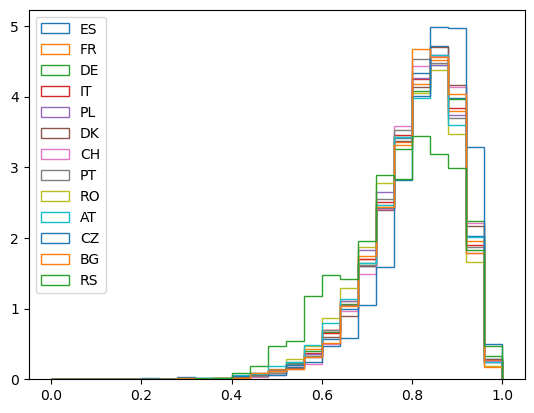

In [14]:
for country, time_series in adjusted_loads_by_country.items():
    if len(time_series) > 50:
        plt.hist(ts.compute_pairwise_correlations(time_series), range=(0,1), bins=25, histtype='step', density=True, label=country)
plt.legend()
plt.show()

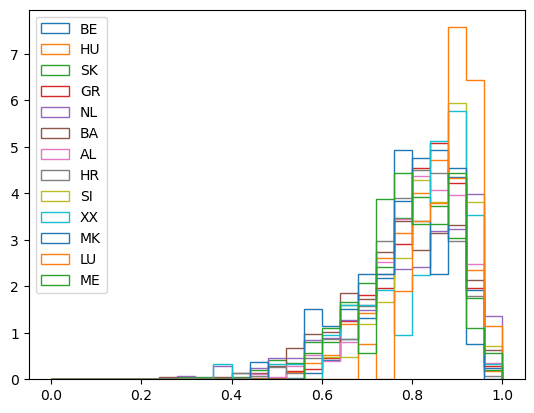

In [15]:
for country, time_series in adjusted_loads_by_country.items():
    if len(time_series) <= 50:
        plt.hist(ts.compute_pairwise_correlations(time_series), range=(0,1), bins=25, histtype='step', density=True, label=country)
plt.legend()
plt.show()

Since each country's load profile has specific characteristics, the overall correlation between all time series has a broader distribution:

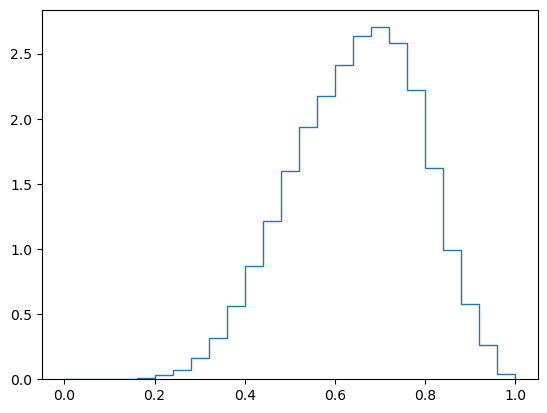

In [16]:
plt.hist(ts.compute_pairwise_correlations(np.concatenate(list(adjusted_loads_by_country.values()))),
         range=(0,1), bins=25, histtype='step', density=True)
plt.show()

### Export the time series

Combine all time series into an array:

In [17]:
all_time_series = np.array([adjusted_loads_by_country[load_countries[i]][load_labels[i]] for i in range(n_loads)])

In [18]:
assert all_time_series.shape == (n_loads, 364 * 24)

Define a dataframe containing all time series, with time steps as columns and loads as rows:

In [25]:
time_series_df = pd.DataFrame(all_time_series, index=load_ids)
time_series_df.index.name = 'id'
time_series_df

,0,1,2,3,4,5,6,7,8,9,...,8726,8727,8728,8729,8730,8731,8732,8733,8734,8735
id,,,,,,,,,,,,,,,,,,,,,
81,1.074461,1.077165,1.106095,1.172570,1.347911,1.518431,1.655755,1.699970,1.661393,1.639479,...,1.312605,1.424851,1.498897,1.477789,1.437977,1.369934,1.301289,1.214587,1.128353,1.075703
82,0.989639,1.000056,1.056743,1.157221,1.383230,1.616894,1.809335,1.842433,1.759526,1.721865,...,1.172849,1.286491,1.373892,1.343649,1.299676,1.223850,1.155578,1.073052,0.994289,0.958175
83,0.799421,0.792595,0.783618,0.779404,0.737500,0.740960,0.832471,0.908241,0.929757,0.904896,...,0.863270,0.955206,1.012509,0.994409,0.976842,0.952091,0.962827,0.909950,0.875894,0.832059
84,0.960038,0.960873,0.967241,1.006887,1.112149,1.238253,1.362594,1.434374,1.439662,1.437743,...,1.330124,1.412866,1.444807,1.400860,1.351639,1.269258,1.219547,1.119301,1.043243,0.985911
85,0.583546,0.554912,0.542927,0.534712,0.485055,0.472332,0.554960,0.636159,0.658376,0.637063,...,0.654164,0.764718,0.821211,0.803824,0.770702,0.745931,0.737061,0.722436,0.670346,0.632238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7888,0.830736,0.779552,0.751104,0.740337,0.759151,0.831444,0.956032,1.082531,1.190287,1.238981,...,0.967621,0.946841,0.962938,1.075379,1.138475,1.173170,1.186193,1.140504,1.044813,0.925321
7889,0.828896,0.743694,0.713771,0.715476,0.736938,0.778183,0.891081,1.076959,1.301331,1.440353,...,0.854656,0.850381,0.862777,0.924284,0.981948,1.003407,1.015884,0.991315,0.940704,0.850944
7890,0.834343,0.814289,0.814168,0.831980,0.876333,0.967987,1.089970,1.160623,1.189053,1.214579,...,0.941105,0.954356,1.019742,1.045686,1.033445,0.997484,0.960667,0.947831,0.905605,0.861403


Export to CSV format:

In [27]:
time_series_df.to_csv("data/europe_load_series.csv", mode='x')

The whole procedure can be iterated multiple times to generate more than one time series for each load.

In [2]:
# for label in range(0,10):
#     adjusted_loads_by_country = {country: generate_time_series(country, count, std_scaling_by_country[country])
#                                  for country, count in load_count_by_country.items()}
#     all_time_series = np.array([adjusted_loads_by_country[load_countries[i]][load_labels[i]] for i in range(n_loads)])
#     time_series_df = pd.DataFrame(all_time_series, index=load_ids)
#     time_series_df.index.name = 'id'
#     filename = "data/europe_load_series_%02d.csv" % label
#     print("Writing to file '%s'..." % filename, end='')
#     time_series_df.to_csv(filename, mode='x')
#     print("ok")

## Generators

Get the list of generators:

In [30]:
gen_ids = [int(id) for id in network['gen'].keys()]
gen_ids.sort()

n_gens = len(gen_ids)
n_gens

1083

Generate noise series with zero mean and standard deviation equal to 0.1:

In [31]:
noise_time_series = 0.1 * ts.generate_noise(count=n_gens)

In [32]:
noise_time_series.mean(), noise_time_series.std(axis=1).mean()

(-2.5807384089171404e-16, 0.10007235927932408)

Pack everything into a dataframe, with time steps as columns and generators as rows:

In [33]:
noise_time_series_df = pd.DataFrame(noise_time_series, index=gen_ids)
noise_time_series_df.index.name = 'id'
noise_time_series_df

,0,1,2,3,4,5,6,7,8,9,...,8726,8727,8728,8729,8730,8731,8732,8733,8734,8735
id,,,,,,,,,,,,,,,,,,,,,
1,0.081570,0.075651,0.099532,-0.009748,0.094776,0.106689,-0.047293,0.008208,0.012441,-0.085597,...,0.027670,-0.022528,0.075986,0.111013,0.101727,0.104259,0.085309,0.067874,0.126277,0.191748
2,-0.120256,-0.150132,-0.275556,-0.120543,-0.096194,-0.217515,-0.181542,-0.130463,-0.121752,-0.163943,...,-0.077128,0.037056,0.055544,-0.030048,-0.076115,-0.071544,-0.021066,-0.086959,-0.100221,-0.137720
3,-0.067273,0.011333,0.029559,-0.067696,-0.036859,0.090736,-0.011750,-0.029253,0.050073,-0.051534,...,0.063155,0.057434,0.064052,-0.026471,-0.058892,0.004851,0.007125,-0.129120,-0.220265,-0.154182
4,0.119044,0.113859,0.174069,0.216205,0.168437,0.111145,0.181610,0.202403,0.113077,0.127222,...,0.126793,0.124681,0.097180,0.080506,0.148291,0.129162,0.084781,0.105705,0.179465,0.199275
5,-0.003353,0.006686,-0.034807,0.075815,0.007294,-0.082808,0.006344,0.012972,-0.013176,-0.022415,...,-0.042169,-0.035568,-0.067719,-0.036879,-0.077249,-0.028916,0.031387,-0.017624,-0.000778,-0.037277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,-0.049878,0.088939,-0.053340,-0.186266,-0.068903,0.056847,-0.074158,-0.146306,-0.093589,-0.006481,...,0.032651,-0.181021,-0.201883,0.030159,-0.090382,-0.264728,-0.254432,-0.072704,-0.149588,-0.302865
1080,0.037598,-0.041362,-0.029851,-0.133510,-0.034514,-0.050249,0.028765,0.057047,-0.058052,0.074866,...,0.004009,-0.087367,0.049679,-0.049897,-0.094339,-0.027339,-0.138065,0.018659,-0.005752,0.024886
1081,0.101653,0.181731,0.106339,0.050193,-0.099072,-0.057434,0.117443,0.056855,-0.014489,-0.080953,...,0.112062,0.095548,0.040224,0.054215,0.231931,0.199481,0.080727,0.101570,0.094496,0.017577


Export to CSV format:

In [34]:
noise_time_series_df.to_csv('data/europe_noise_series.csv', mode='x')

As with the loads, the whole procedure can be iterated:

In [1]:
# for label in range(0,10):
#     df = pd.DataFrame(0.1 * ts.generate_noise(count=n_gens), index=gen_ids)
#     df.index.name = 'id'
#     filename = "data/europe_noise_series_%02d.csv" % label
#     print("Writing to file '%s'..." % filename, end='')
#     df.to_csv(filename, mode='x')
#     print("ok")